# Introduction

As this figure included a PNG image produced using IGV, this figure was produced using the Inkscape graphical software. This notebook instructs the creation of this PNG image from sequence reads as well as the upsetplots used. 

# Figure

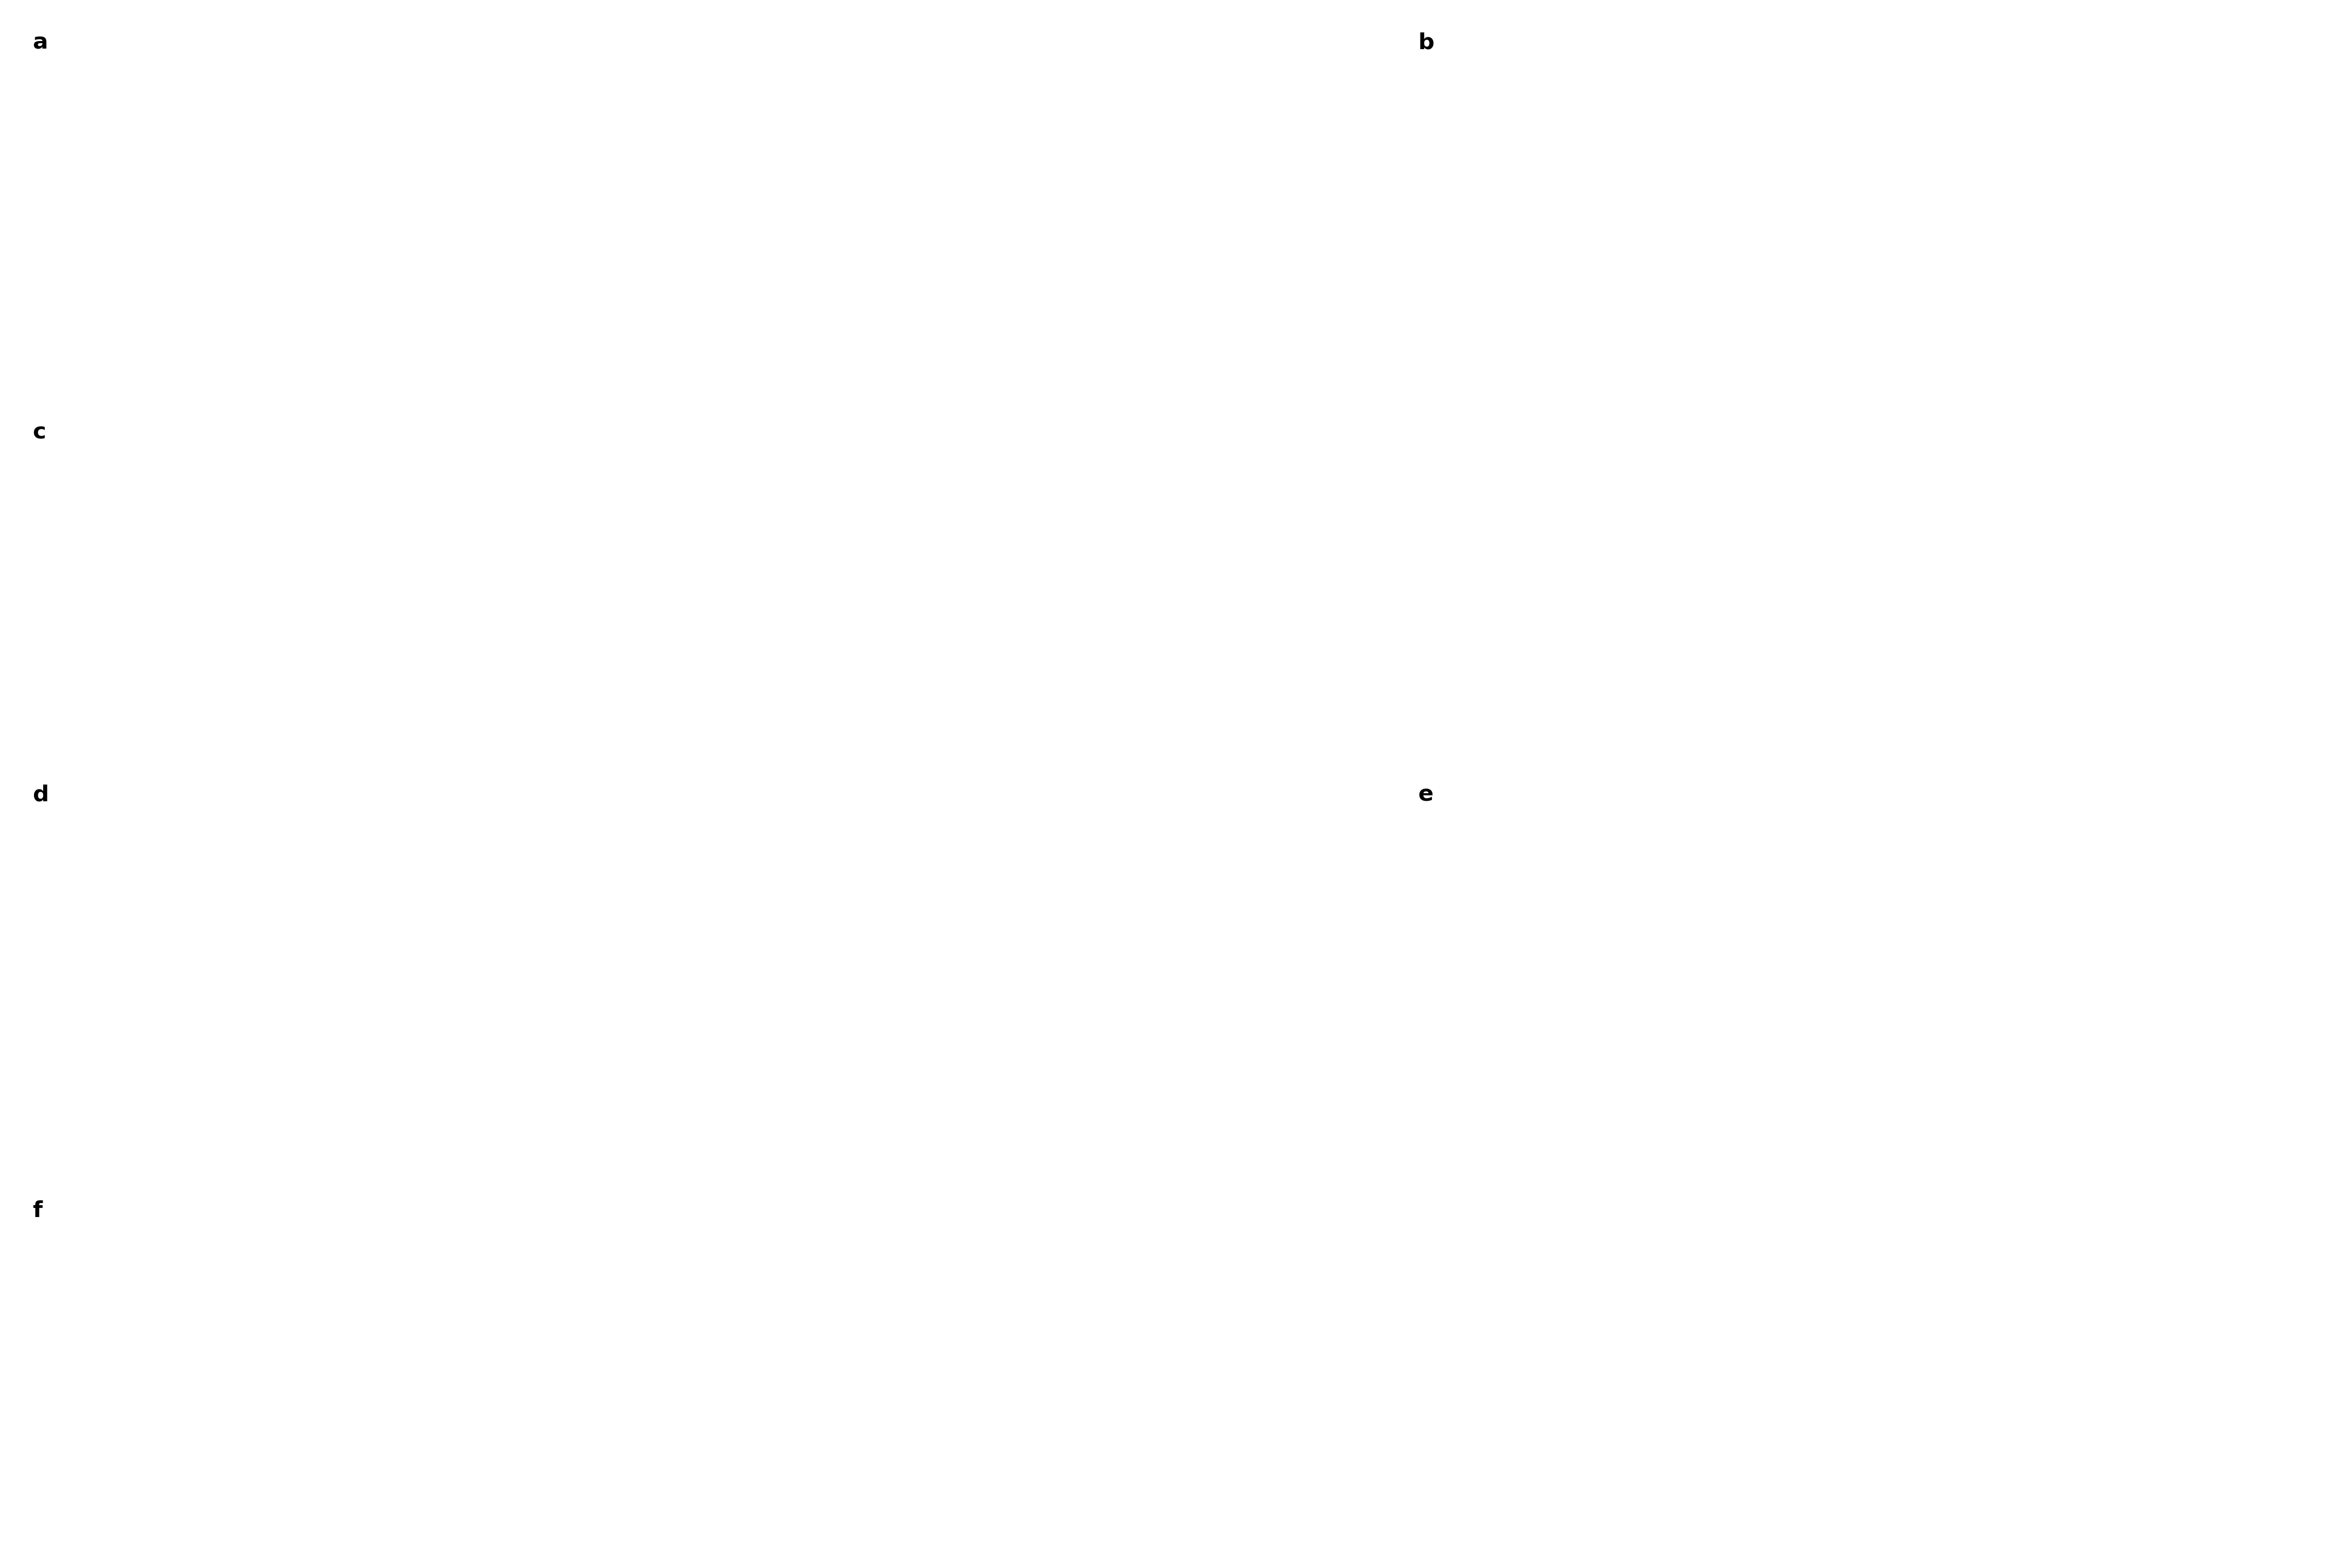

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from PIL import Image
import string
import seaborn as sns

# Fig main # 

mpl.rc('font', size=5)
fig = plt.figure(figsize=(180/25.4, 120/25.4),   
                 dpi=600, layout="constrained")

gs = GridSpec(4, 5, fig)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[:2, 3:])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[2, :3])
ax5 = fig.add_subplot(gs[2:, 3:])
ax6 = fig.add_subplot(gs[3, :3])

for i, ax in enumerate(fig.axes):
    ax.set_title(string.ascii_lowercase[i], fontdict={"weight" : "bold",
                                                      "fontsize" : 5},
                                                      loc="left")
for ax in fig.axes:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.tick_params("both", bottom=False, left=False, 
                   labelbottom=False, labelleft=False)

fig.savefig("plots/f3_canvas_w_barplot.svg")

 # Upsetplot - all reads

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import upsetplot

root_path = "data/duplex_data/patterns/"
files = ["CBM_2_rep1.masked.bed.duplex_patterns.tsv", "CBM_3_rep1.sorted.bam.bed.duplex_patterns.tsv",
         "CBM_2_rep2.masked.bed.duplex_patterns.tsv", "CBM_3_rep2.sorted.bam.bed.duplex_patterns.tsv"]

file_paths = [root_path + file for file in files]

patterns = pd.concat([pd.read_table(path) for path in file_paths])
patterns_grouped = patterns.groupby("Pattern")["N_Pattern"].sum()

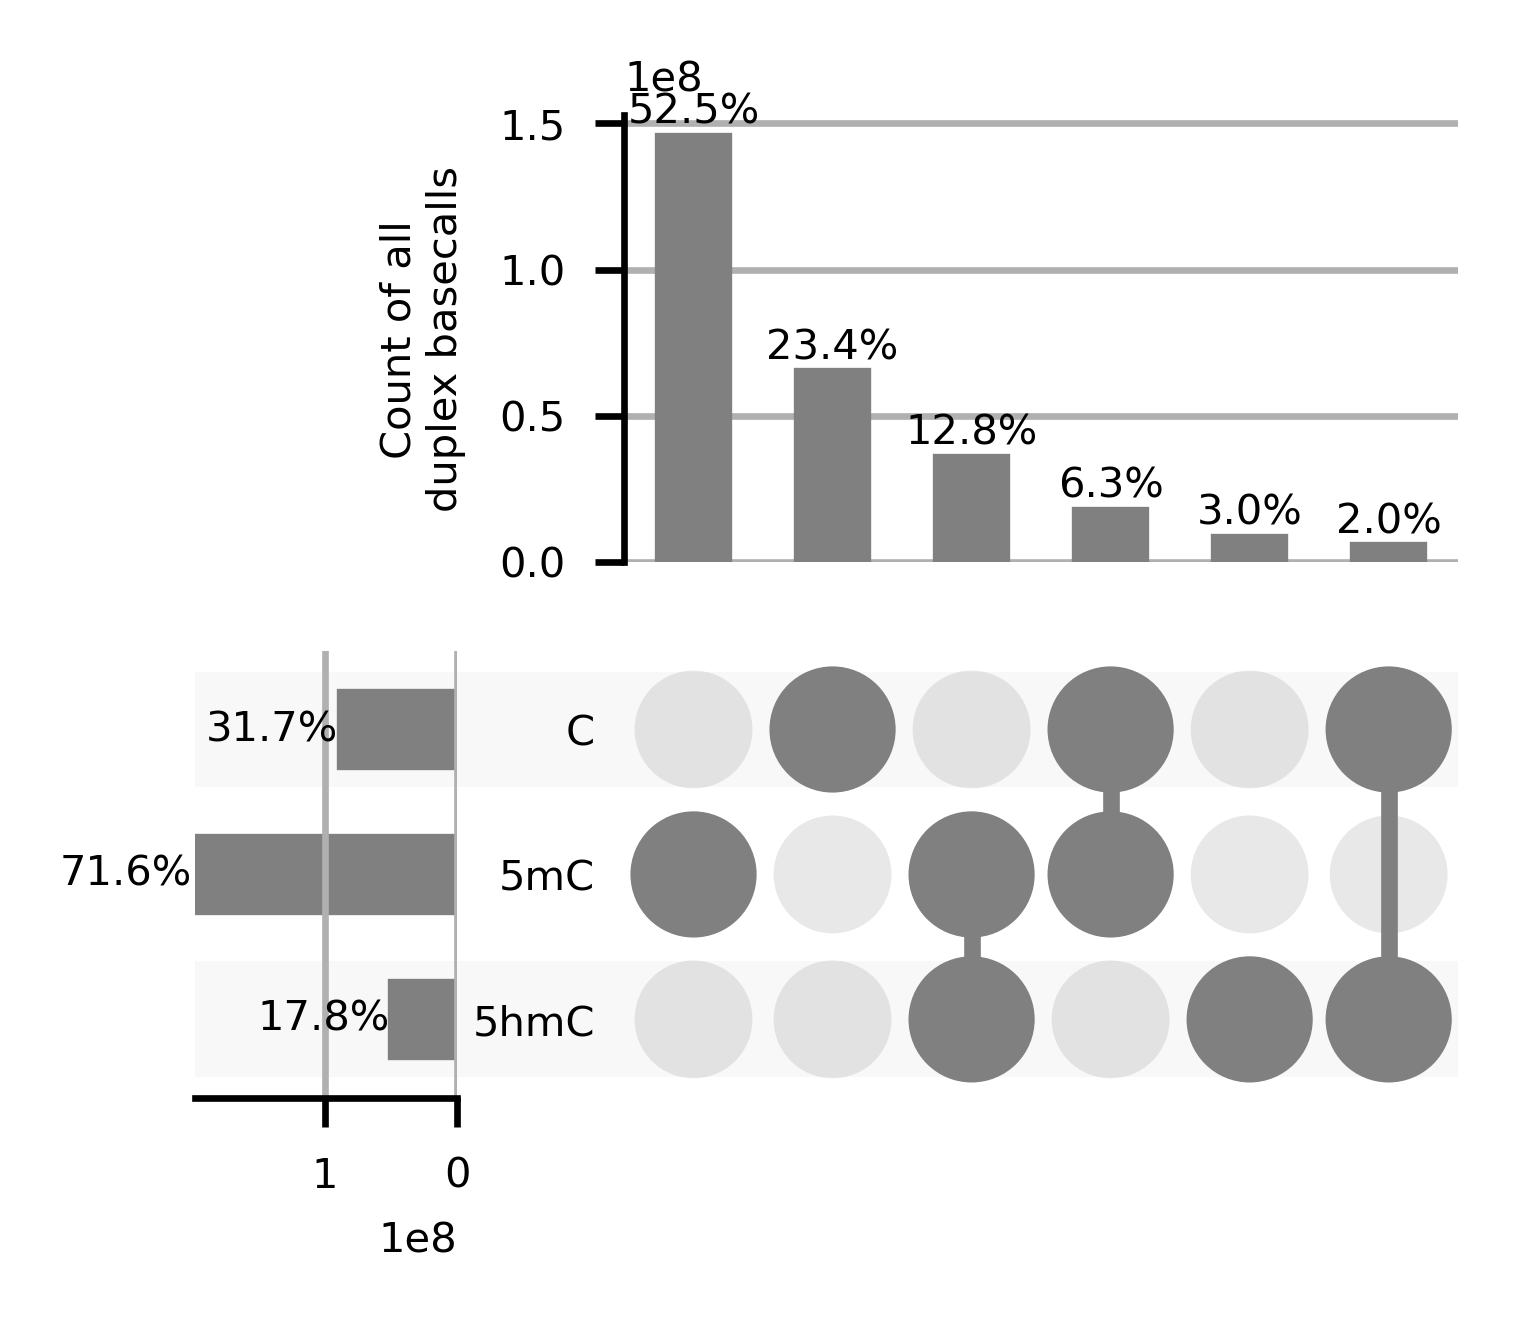

In [3]:

upsetplot_all_reads = upsetplot.from_memberships(
    memberships=[
["C"], 
["5mC"],
["C", "5mC"],
["5hmC"],
["5mC", "5hmC"],
["C", "5hmC"]],
    data = [
    patterns_grouped["-,-,C"], 
    patterns_grouped["m,m,C"], 
    patterns_grouped["-,m,C"] + patterns_grouped["m,-,C"] , 
    patterns_grouped["h,h,C"], 
    patterns_grouped["h,m,C"] + patterns_grouped["m,h,C"], 
    patterns_grouped["-,h,C"] + patterns_grouped["h,-,C"]] 
)
upset_all_reads = upsetplot.UpSet(upsetplot_all_reads, sort_by="cardinality", sort_categories_by="input", show_percentages=True,
                                  element_size=None,
                                  facecolor="grey",
                                  intersection_plot_elements=3)

upset_all_fig = plt.figure(figsize=(69/25.4, 54/25.4),   
                           dpi=600)
upset_all_reads.plot(upset_all_fig)

upset_all_fig.axes[-1].set_ylabel("Count of all\nduplex basecalls")

upset_all_fig.savefig("plots/fig3_upset_all.svg")

# Allele-sorted nanopore IGV
This section instructs how reads were extracted to produce an allele-sorted view of imprinting sites. 

In [4]:
import pandas as pd
from pathlib import Path
from AnalysisTools import fetch_reads_from_modkit

path_base = "data/duplex_data/dmr/readcalls"
files = [file for file in Path(path_base).glob("*")]
include_bed = "feature_references/dmr/mm39_dmr_coordinates_modified.bed"
all_replicates = []

for i, file in enumerate(files):
    dup_read_table = fetch_reads_from_modkit.ModkitExtract(file).cpg_table
    dup_read_table.set_include_bed(include_bed)

    all_genes = []
    m_reads_all = []
    u_reads_all = []
    for gene in dup_read_table.include_bed["Name"]:
        try:
            m_reads = len(dup_read_table.select_gene(gene).get_methylated_readIDs(minimum_read_proportion=.25, min_cpg_proportion=.25))
            u_reads = len(dup_read_table.select_gene(gene).get_unmethylated_readIDs(minimum_read_proportion=.25, min_cpg_proportion=.25))
            gene_df = pd.DataFrame(dict(gene_name = gene, read_type = ["Methylated", "Unmethylated"], count=[m_reads, u_reads]))
            all_genes.append(gene_df)
        except:
            print(f"Failed at {gene} in replicate {i}")
            pass

    all_genes_df = pd.concat(all_genes).assign(Replicate = i)
    all_replicates.append(all_genes_df)
all_replicates_df = pd.concat(all_replicates).reset_index(drop=True)

Failed at Snrpn in replicate 0


# Allele sorted upset plots

In [5]:
import pandas as pd
import numpy as np

def calculate_proportion(df):
    sum_val = df["N_Pattern"].sum()
    df = df.eval("Proportion = (N_Pattern / @sum_val)*100")
    df["Natural_log"] = np.log(df["Proportion"])
    return df

def replacer(df):
    return df.replace(["-,m,C", "m,-,C", "-,h,C", "h,-,C", "m,h,C", "h,m,C", "-,-,C", "m,m,C", "h,h,C"], 
                      ["C:5mC", "C:5mC", "C:5hmC", "C:5hmC", "5mC:5hmC", "5mC:5hmC", "C:C", "5mC:5mC", "5hmC:5hmC"])

root_path = "data/duplex_data/patterns/"
files = ["CBM_2_rep1.masked.bed.duplex_patterns.tsv", "CBM_3_rep1.sorted.bam.bed.duplex_patterns.tsv",
         "CBM_2_rep2.masked.bed.duplex_patterns.tsv", "CBM_3_rep2.sorted.bam.bed.duplex_patterns.tsv"]

file_paths = [root_path + file for file in files]

patterns = pd.concat([pd.read_table(path) for path in file_paths])
patterns_grouped = patterns.groupby("Pattern")["N_Pattern"].sum()

In [6]:
paths = ["data/duplex_data/duplex_icrs/duplex_patterns/all_methylated.extract.bed.duplex_patterns.tsv", 
         "data/duplex_data/duplex_icrs/duplex_patterns/all_unmethylated.extract.bed.duplex_patterns.tsv"]

meth_unmeth = map(replacer, [pd.read_table(path).groupby("Pattern")["N_Pattern"].sum().reset_index() for path in paths])
meth_unmeth = pd.concat([df.assign(Allele = allele) for df, allele in zip(map(calculate_proportion, meth_unmeth), ["Methylated", "Unmethylated"])])

meth_unmeth = meth_unmeth.groupby(["Pattern", "Allele"]).sum(numeric_only=True).reset_index()

In [7]:
patterns_grouped = calculate_proportion(replacer(patterns_grouped.reset_index()))
patterns_grouped["Allele"] = "Genome average"

data = pd.concat([meth_unmeth, patterns_grouped]).groupby(["Pattern", "Allele"]).sum(numeric_only=True).reset_index()

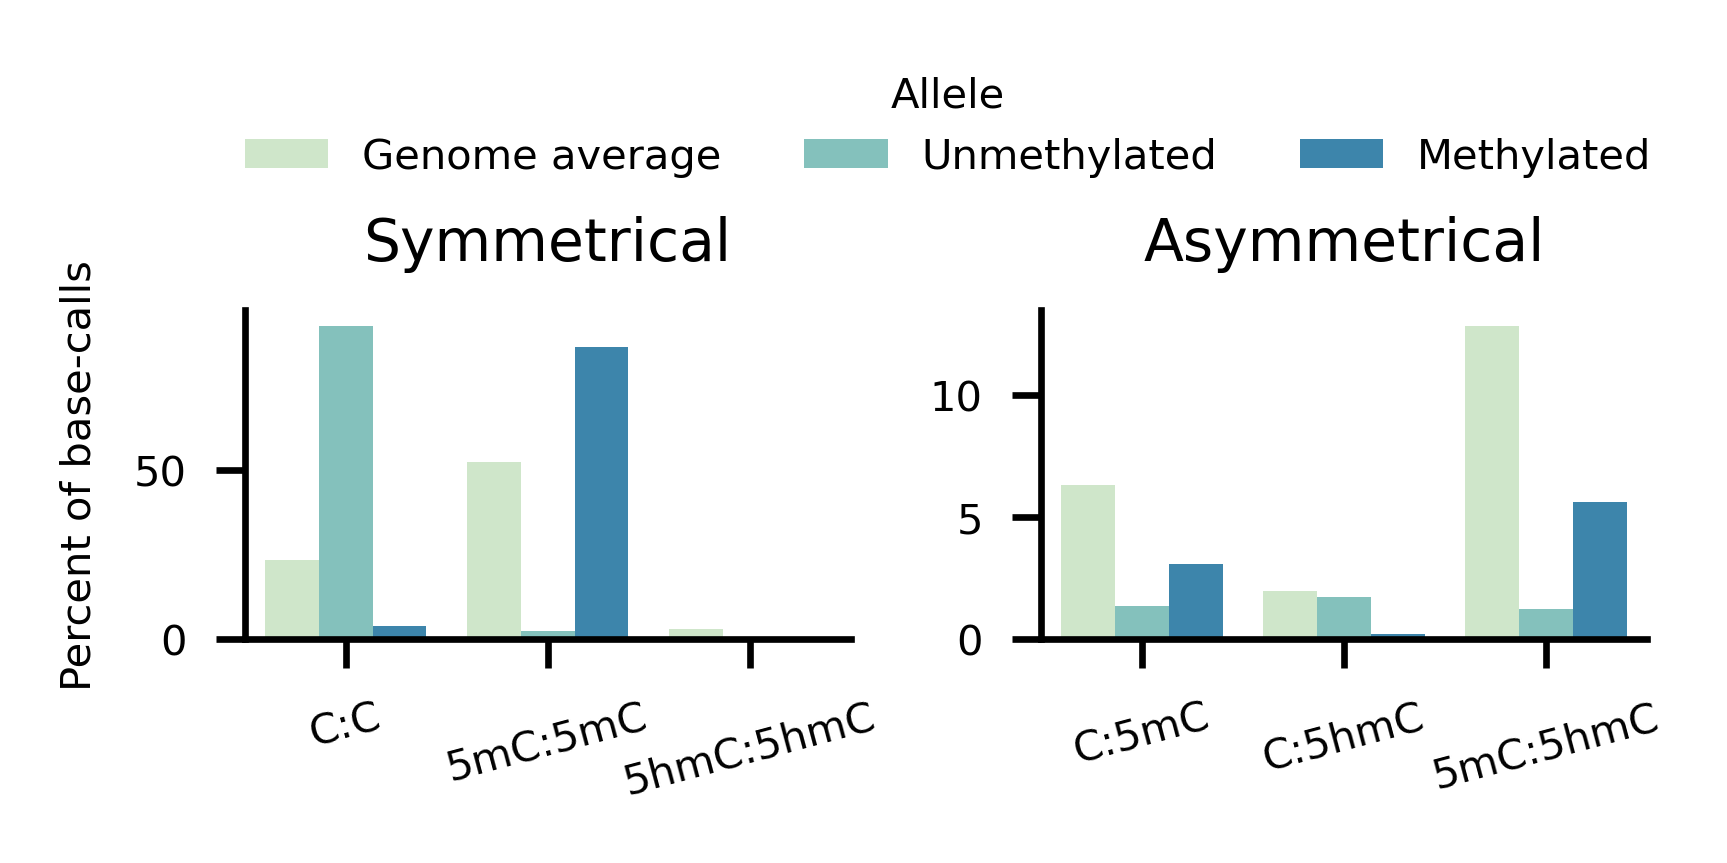

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("font", size=5)

fig, axes = plt.subplots(1, 2, figsize=(70/25.4, 27/25.4), dpi=600, layout="constrained")

ax1, ax2 = axes.flatten()

sns.barplot(data, 
            x="Pattern", y="Proportion", 
            hue="Allele",
            palette="GnBu",
            legend=True,
            order=["C:C", "5mC:5mC", "5hmC:5hmC"],
            hue_order=["Genome average", "Unmethylated", "Methylated"],
            ax=ax1)

ax1.set_ylabel("Percent of base-calls")
ax1.set_title("Symmetrical", fontsize=7)
handles, labels = ax1.get_legend_handles_labels()

sns.barplot(data, 
            x="Pattern", y="Proportion", 
            hue="Allele",
            legend=False,
            palette="GnBu",
            order=["C:5mC", "C:5hmC", "5mC:5hmC"],
            hue_order=["Genome average", "Unmethylated", "Methylated"],
            ax=ax2)

ax2.set_ylabel(None)
ax2.set_title("Asymmetrical", fontsize=7)

ax1.get_legend().remove()
fig.legend(handles, labels, loc="center right", ncols=3, title="Allele", frameon=False, bbox_to_anchor=(1, 1.1))

for ax in [ax1, ax2]:
    ax.set_xlabel(None)
    ax.tick_params("x", labelrotation=15)

sns.despine()

with pd.ExcelWriter('source_data/fig4_duplex.xlsx') as writer:
    patterns_grouped.to_excel(writer, 'fig4b_upsetplot_patterns')
    data.to_excel(writer, 'fig4d_pattern_percentages')

fig.savefig("plots/proportion_of_basecalls.svg")

# Comparison: ICR vs whole genome dyad composition

In [9]:
from scipy import stats

root_path = "data/duplex_data/patterns/"
files = ["CBM_2_rep1.masked.bed.duplex_patterns.tsv", "CBM_3_rep1.sorted.bam.bed.duplex_patterns.tsv",
         "CBM_2_rep2.masked.bed.duplex_patterns.tsv", "CBM_3_rep2.sorted.bam.bed.duplex_patterns.tsv"]

genome = [root_path + file for file in files]
dmrs = ["data/duplex_data/duplex_icrs/duplex_patterns/all_methylated.extract.bed.duplex_patterns.tsv", 
        "data/duplex_data/duplex_icrs/duplex_patterns/all_unmethylated.extract.bed.duplex_patterns.tsv"]

meth, unmeth = map(pd.read_table, dmrs)
meth["Allele"], unmeth["Allele"] = "Methylated", "Unmethylated"
bg = pd.concat(map(pd.read_table, genome)).groupby("Pattern").sum(True).reset_index().assign(Allele = "Genome")

all_duplex_count = bg["N_Pattern"].sum()
bg["Proportion"] = bg.eval("N_Pattern / @all_duplex_count")

meth["Expected"], unmeth["Expected"] = map(lambda df: round(df["N_Pattern"] * bg["Proportion"]), [meth, unmeth])

In [10]:
observed = np.array([meth["N_Pattern"], meth["Expected"]])

stats.chi2_contingency(observed, lambda_="log-likelihood")

Chi2ContingencyResult(statistic=1030.4443533470653, pvalue=4.0014310208599055e-217, dof=8, expected_freq=array([[6.35217198e+02, 1.36166602e+01, 1.64080755e+02, 1.15741612e+01,
        6.19558038e+01, 3.82628151e+02, 2.53950712e+02, 4.03733974e+02,
        1.73292426e+04],
       [2.97782802e+02, 6.38333982e+00, 7.69192448e+01, 5.42583884e+00,
        2.90441962e+01, 1.79371849e+02, 1.19049288e+02, 1.89266026e+02,
        8.12375742e+03]]))

In [11]:
from scipy import stats

observed = np.array([unmeth["N_Pattern"], unmeth["Expected"]])

stats.chi2_contingency(observed, lambda_="log-likelihood")

Chi2ContingencyResult(statistic=357.08332910956796, pvalue=2.784359779373352e-72, dof=8, expected_freq=array([[1.96114564e+04, 1.45306126e+02, 1.21764910e+02, 1.53423786e+02,
        7.79295422e+01, 1.09588419e+02, 1.15270781e+02, 1.12835483e+02,
        6.36424595e+02],
       [4.54754364e+03, 3.36938744e+01, 2.82350903e+01, 3.55762138e+01,
        1.80704578e+01, 2.54115813e+01, 2.67292188e+01, 2.61645170e+01,
        1.47575405e+02]]))